In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 26.2 MB/s 
     |████████████████████████████████| 596 kB 59.2 MB/s 
     |████████████████████████████████| 101 kB 13.7 MB/s 
     |████████████████████████████████| 6.6 MB 65.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip install text_hammer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 115 kB 30.0 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


## **Importing Main Libraries**

In [3]:
from transformers import AutoTokenizer, TFBertModel
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense
import tensorflow as tf
import pandas as pd
import numpy as np
import text_hammer as th
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import shutil

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Data Exploration**

In [5]:
my_data = pd.read_csv("/content/drive/MyDrive/reviews.csv")
my_data.head(3)

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN


In [6]:

%%time

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
#     df[column] = df[column].progress_apply(lambda x: ps.remove_stopwords(x))

    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
#     df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

CPU times: user 640 µs, sys: 0 ns, total: 640 µs
Wall time: 669 µs


In [7]:
# lets get cleaned data
df_cleaned = text_preprocessing(my_data,'Review')

  0%|          | 0/61594 [00:00<?, ?it/s]

  0%|          | 0/61594 [00:00<?, ?it/s]

  0%|          | 0/61594 [00:00<?, ?it/s]

  0%|          | 0/61594 [00:00<?, ?it/s]

  0%|          | 0/61594 [00:00<?, ?it/s]

  0%|          | 0/61594 [00:00<?, ?it/s]

In [8]:
df_cleaned['num_words'] = df_cleaned.Review.apply(lambda x:len(x.split()))

In [9]:
df_cleaned.num_words.max()

719

there is something not normal 719 is not appropriate number so lets check what is wrong

In [10]:
df_cleaned = df_cleaned[df_cleaned['num_words']<70] # lets drob numberes bigger than 70

In [11]:
df_cleaned['Rating'] = df_cleaned.Rating.astype('category')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


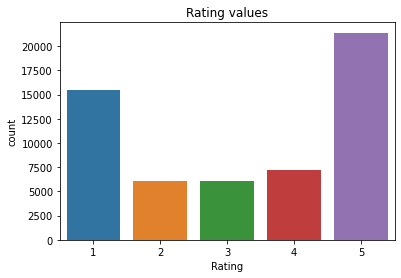

In [12]:
plt.title("Rating values")
sns.countplot('Rating',data=df_cleaned)

In [13]:
data_train,data_test = train_test_split(df_cleaned, test_size = 0.3, random_state = 42, stratify = df_cleaned.Rating)

In [14]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [15]:
# for saving model locally and we can load it later on 
tokenizer.save_pretrained('bert-tokenizer')
bert.save_pretrained('bert-model')
shutil.make_archive('bert-tokenizer', 'zip', 'bert-tokenizer')
shutil.make_archive('bert-model','zip','bert-model')

'/content/bert-model.zip'

In [16]:
# Tokenize the input (takes some time) 
# here tokenizer using from bert-base-cased
x_train = tokenizer(
    text=data_train.Review.tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


x_test = tokenizer(
    text=data_test.Review.tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [17]:
# cheking GPU
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [24]:
max_len = 70
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")


embeddings = bert(input_ids,attention_mask = input_mask)[0] #(0 is the last hidden states,1 means pooler_output)
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(30,activation = 'relu')(out)

y = Dense(6,activation = 'sigmoid')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True
# for training bert our lr must be so small

In [25]:
optimizer = Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

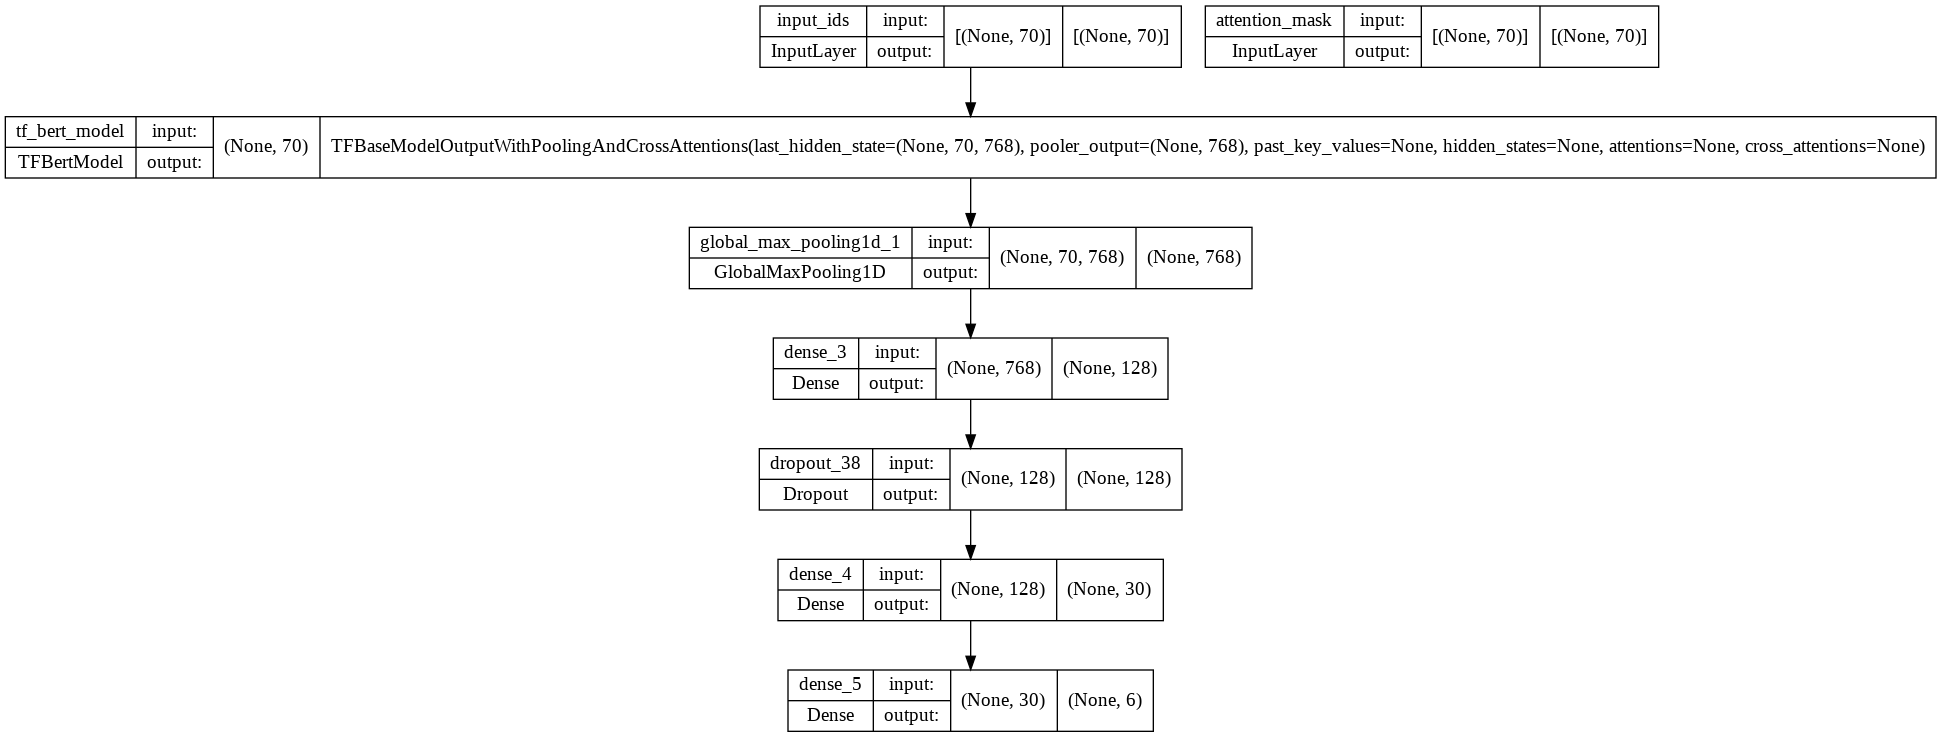

In [26]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [27]:
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)

In [28]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = to_categorical(data_train.Rating),
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, to_categorical(data_test.Rating)
    ),
  epochs=1,
    batch_size=36
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1094/1094 [==============================] - 847s 773ms/step - loss: 0.9554 - balanced_accuracy: 0.6385 - val_loss: 0.8984 - val_balanced_accuracy: 0.6574


In [29]:
predicted_raw = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})
y_predicted = np.argmax(predicted_raw, axis = 1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [30]:
print(classification_report(data_test.Rating, y_predicted))

              precision    recall  f1-score   support

           1       0.60      0.91      0.72      4643
           2       0.27      0.01      0.02      1823
           3       0.34      0.25      0.29      1810
           4       0.45      0.42      0.43      2171
           5       0.86      0.86      0.86      6419

    accuracy                           0.66     16866
   macro avg       0.50      0.49      0.46     16866
weighted avg       0.61      0.66      0.61     16866

